# DATA 604 - Final Project
### Simulation and Modeling Techniques

# Sharpe Ratio Optimization via Monte Carlo Simulation

Author: Mael Illien

#### Introduction & Setup

#### Problem and Significance

This goal of this project is to optimize the Sharpe ratio of a portfolio via simulation. This Monte Carlo simulation is significant in its usage to investors in determining the allocation of stock positions in a portfolio that maximizes risk adjusted returns. The way this high-return low-volativity measure will be evaluated is through the use of the Sharpe ratio. The ratio is used to evaluate whether a portfolio's returns were good investments and not the result of excess risk.

Using an allocation optimized for Sharpe ratio from the previous year could yield good returns if applied to the current year. However, this would be done with the understanding that this allocation does not garantee consistent results when new unseen data is used.  

#### Sharpe Ratio

For reference, a Sharpe ratio above 1 is considered acceptable, above 2 is very good and beyond 3 is excellent.

$$SR = \frac{R_p-R_f}{\sigma_p}$$

$$R_p = return\ of\ portfolio$$
$$R_f = risk\ free\ rate\ (assumed\ to\ be\ 0)$$
$$\sigma_p = standard\ deviation\ of\ portfolio.$$


#### Methodology

This work builds upon simulation elements presented in the ModSimPy library and associated text. While the ModSimPy library is not explicitly used in the code presented, the same methodologies are applied.

The simulation works with a handful of stocks whose daily returns for the year 2019 are used to update a portfolio object with random initial allocation weights on every iteration. We are replicating a "buy and hold" strategy where the stocks are "bought" on day 0 and are held until the end of the simulation. The simulation is run 500 times, which proved to be a good compromise between a variety of portfolio returns and run time. 

## Flowchart

As visualized in the flowchart, the simulation is broken down into the following steps:

- Initialize simulation parameters
- Initialize arrays to store the simulation results
- Build System object
- Simulate num_ports portfolios. For every portfolio:
    - Assign random initial weights
    - Build Portfolio object initialized to starting capital
    - For every time step t of System:
        - Update Portfolio holdings via daily stock returns
        - Record capital
    - Compute and record metrics for simulated portfolio
    
Once the simulation is run, the 'best portfolio' will be selected based on the maximum sharpe ratio achieved. 

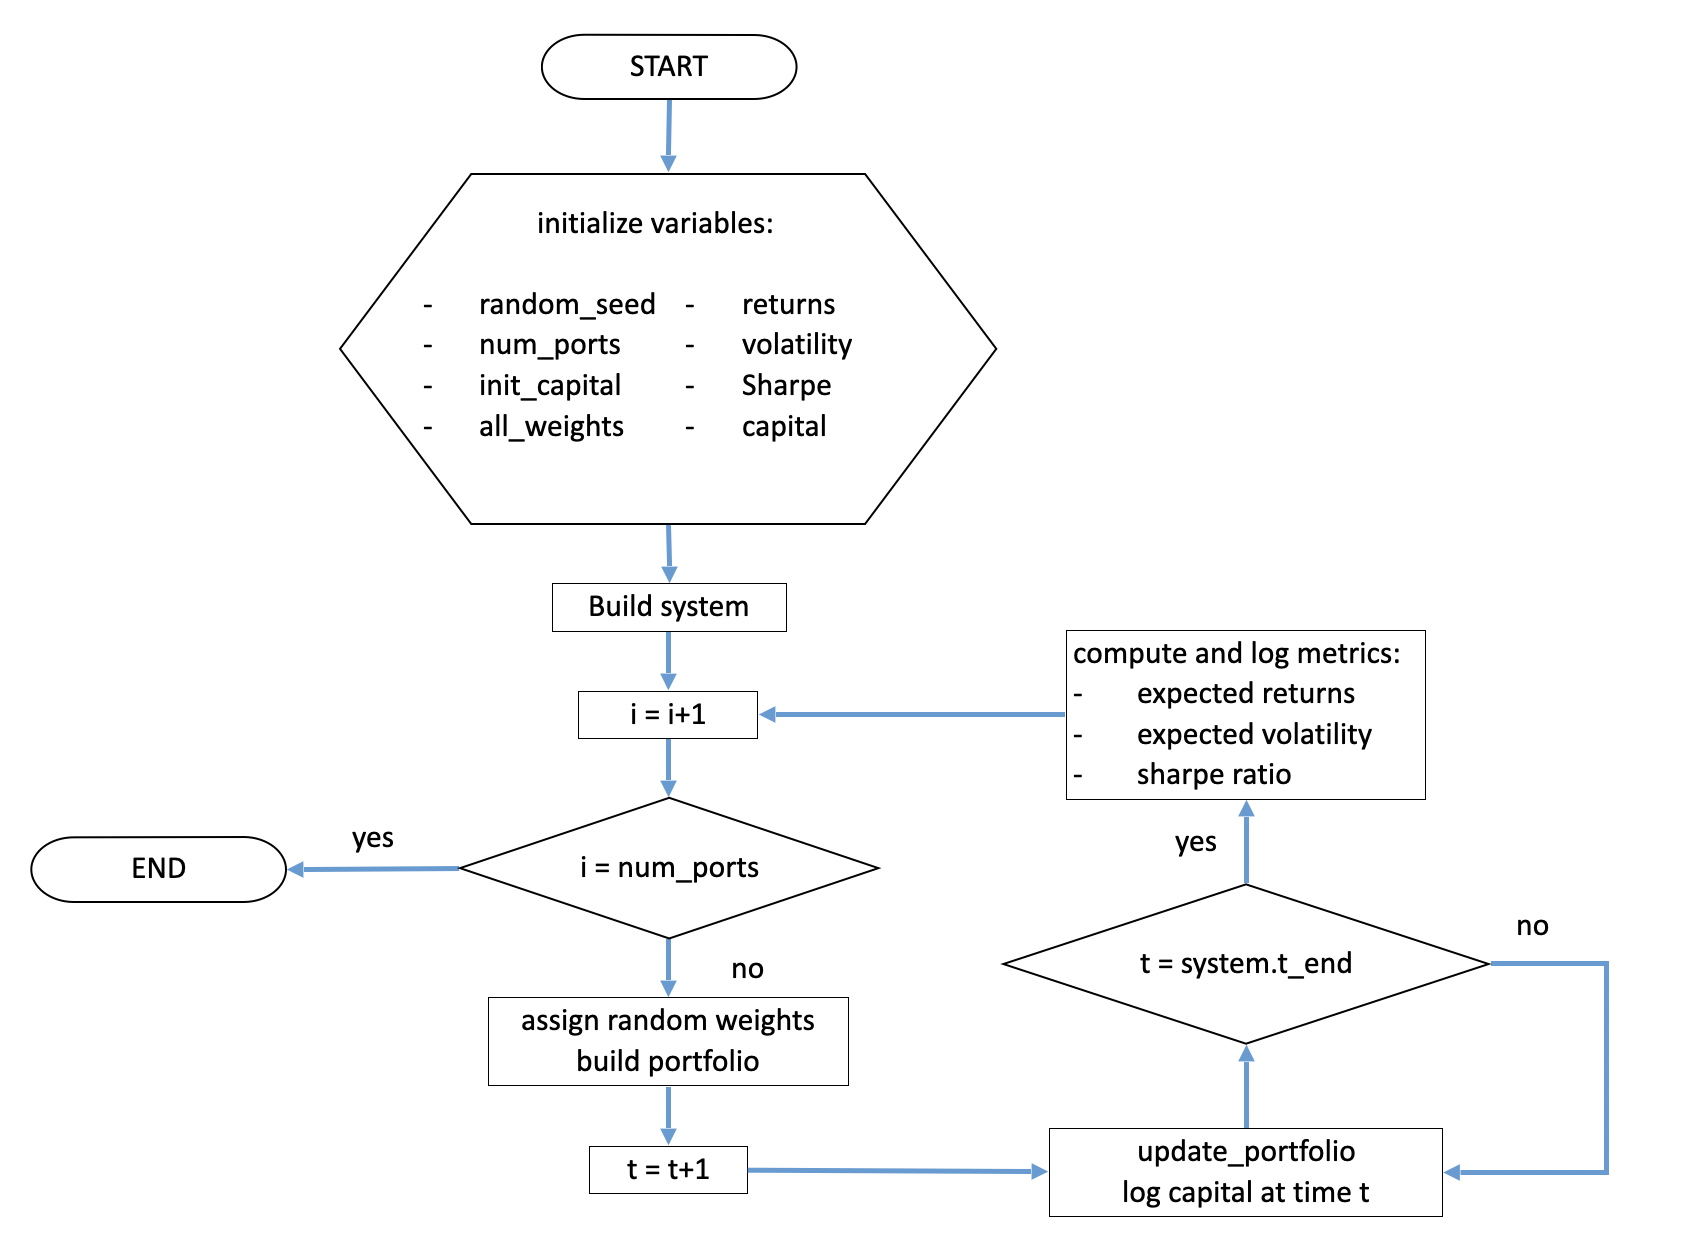

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename="./flowchart.png",width=700, height=600)

In [2]:
import os
import numpy as np
import pandas as pd
import random
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

## Data Import

The data is contained in flat files, generated from a stock price database maintained by the author. Five stocks are selected from various sectors in order to diversify the returns.

In [3]:
stock_names = [file.replace('.csv','') for file in os.listdir('.') if '.csv' in file]
files = [file for file in os.listdir('.') if '.csv' in file]
stock_names

['V', 'BAC', 'NKE', 'AAPL', 'DLTR']

In [4]:
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    df = df.set_index('price_date')
    return df

#### Daily Prices

The daily stock prices are entered in a data frame as follows.

In [5]:
stock_frames = [load_data(file) for file in files]
stocks = pd.concat(stock_frames, axis=1, join='inner')
stocks.columns = stock_names
stocks

,V,BAC,NKE,AAPL,DLTR
price_date,,,,,
2019-01-02,131.6611,24.2500,73.0811,154.7950,91.20
2019-01-03,126.9165,23.8614,71.7884,139.3763,90.76
2019-01-04,132.3842,24.8524,73.6633,145.3261,92.89
2019-01-07,134.7713,24.8330,74.7192,145.0027,97.96
2019-01-08,135.5043,24.7844,75.7158,147.7669,98.60
...,...,...,...,...,...
2019-12-24,186.9857,34.9967,99.8629,282.8313,93.23
2019-12-26,188.5707,35.2948,100.4314,288.4428,92.08
2019-12-27,188.8000,35.1259,101.2890,288.3333,92.84


#### Daily Returns

Stock returns will be used to update the portfolio holdings on every iteration of the system time. Logarithmic returns are often used instead of arithmetic returns. In this assignment we will focus on the later as shown below.

In [6]:
stock_returns = stocks.pct_change(1) # arithmetic stocks returns
stock_log_returns = np.log(stocks/stocks.shift(1)) # logarithmic stocks returns (not used)
stock_returns

,V,BAC,NKE,AAPL,DLTR
price_date,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.036036,-0.016025,-0.017689,-0.099607,-0.004825
2019-01-04,0.043081,0.041532,0.026117,0.042689,0.023468
2019-01-07,0.018032,-0.000781,0.014334,-0.002225,0.054581
2019-01-08,0.005439,-0.001957,0.013338,0.019063,0.006533
...,...,...,...,...,...
2019-12-24,0.002619,0.001422,0.000999,0.000951,0.008546
2019-12-26,0.008477,0.008518,0.005693,0.019840,-0.012335
2019-12-27,0.001216,-0.004785,0.008539,-0.000380,0.008254


## Simulation

The use of System and State objects from ModSimPy is replaced by the objects defined below, allowing for more control over the simulation.

The System object holds a number of attributes include the duration of the simulation, the stock returns to be used for updating portfolios, the names of the stocks traded and an initial capital.

### Objects

In [7]:
class System():
    def __init__(self, stock_returns, init_capital):
        self.t0 = 0
        self.t_end = len(stock_returns)
        self.stock_returns = stock_returns
        self.stock_names = list(self.stock_returns.columns)
        self.init_capital = init_capital

The Porfolio object is analogous to the State object from ModSimPy and will get updated on every system iteratiion by the update_holdings function. It holds a set of initial weights of stock allocations and the holdings data frame which will get iteratively built upon  during the simulation.

In [8]:
class Portfolio():
    def __init__(self, stock_names, init_weights, capital):
        self.init_weights = init_weights
        self.capital = capital
        self.holdings = pd.DataFrame([self.init_weights], columns=stock_names) * capital
        
    def update_holdings(self, daily_returns):
        "Multiply latest holdings by daily_returns at system.t"
        updated_holdings = np.multiply(self.latest_holdings(), [ret+1 for ret in daily_returns])
        self.holdings = self.holdings.append(updated_holdings)
    
    def latest_holdings(self):
        return port.holdings.iloc[[-1]]
    
    def calculate_port_value(self):
        return sum(self.holdings.iloc[-1])

### Monte Carlo Simulation 

In [9]:
# initialize
random.seed(604)
num_ports = 500
init_capital = 1e6
all_init_weights = np.zeros((num_ports, len(stocks.columns)))
returns = np.zeros(num_ports)
volatility = np.zeros(num_ports)
sharpe = np.zeros(num_ports)

# Build system
system = System(stock_returns, init_capital)

capital = np.zeros((system.t_end, num_ports))

# Simulate Portfolio
for i in range(num_ports):
    
    # Assign random weights normalized to sum to 1
    weights = np.array(np.random.random(len(system.stock_names))) 
    init_weights = weights/np.sum(weights)
    all_init_weights[i,:] = init_weights
    
    # Build portfolio and initialize series with the original capital
    port = Portfolio(system.stock_names, init_weights, system.init_capital)
    
    # Initialize capital series with the original capital
    capital[0,i] = port.calculate_port_value()
    
    # Update portfolio holdings daily and record capital at time t
    for t in range(system.t0+1, system.t_end):
        
        daily_returns = system.stock_returns.iloc[t].values.tolist()
        port.update_holdings(daily_returns)
        capital[t,i] = port.calculate_port_value()
    
    # Compute and record metrics
    
    # Record expected average returns (annualized)
    ret = pd.Series(capital[:,i]).pct_change(1)
    returns[i] = ret.mean() * 252

    # Record expected volatility (annualized)
    volatility[i] = ret.std() * (252**0.5) 
     
    # Record Sharpe Ratio (annualized)
    sharpe[i] = returns[i]/volatility[i]

## Results & Findings

The function below selects the best portfolio as determined by the maximum Sharpe Ratio achieved. It also prints out the resulting returns, volality as well as the original weights the portfolio was built from.

In [10]:
def display_results(returns, volatility, sharpe):
    s_arg_max = sharpe.argmax()
    s_max = sharpe.max()
    init_alloc = all_init_weights[s_arg_max]
    #final_alloc = all_final_weights[s_arg_max]/np.sum(all_final_weights[s_arg_max])
    max_sr_ret = returns[s_arg_max]
    max_sr_vol = volatility[s_arg_max]
    
    print("Best Portofolio: {}".format(s_arg_max))
    print("Max Sharpe Ratio achieved: {}".format(round(s_max,3)))
    print("Stocks: {}".format(stock_names))
    print("Inital Weight Allocation: {}".format([round(w, 3) for w in init_alloc]))
    #print("Final Weight Allocation: {}".format([round(w, 3) for w in final_alloc]))
    print("Returns: {}".format(round(max_sr_ret,3)))
    print("Volatility: {}".format(round(max_sr_vol,3)))
    print("Final Portfolio Value: ${:,.2f}".format(capital[-1,sharpe.argmax()]))
    
    plt.figure(figsize=(12,8))
    plt.scatter(volatility, returns, c=sharpe, cmap='plasma')
    plt.colorbar(label='Sharpe Ratio')
    plt.title('Simulated Sharpe Ratios')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    # add a red dot for max_sr_vol & max_sr_ret
    plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

#### Sharpe Ratio Distribution

The scatterplot that follows shows the simulated Sharpe ratios plotted on returns and volality axes, and the distribution of the simulated portfolios. High Sharpe portfolios are more yellow and the maximum is singled out in red. Notice that these simulated portfolios all yield a Sharpe ratio about 1 which is considered good performance. No portfolio holding the 5 selected stocks resulted in a negative return.

Best Portofolio: 401
Max Sharpe Ratio achieved: 2.713
Stocks: ['V', 'BAC', 'NKE', 'AAPL', 'DLTR']
Inital Weight Allocation: [0.311, 0.202, 0.05, 0.408, 0.03]
Returns: 0.49
Volatility: 0.181
Final Portfolio Value: $1,602,591.85


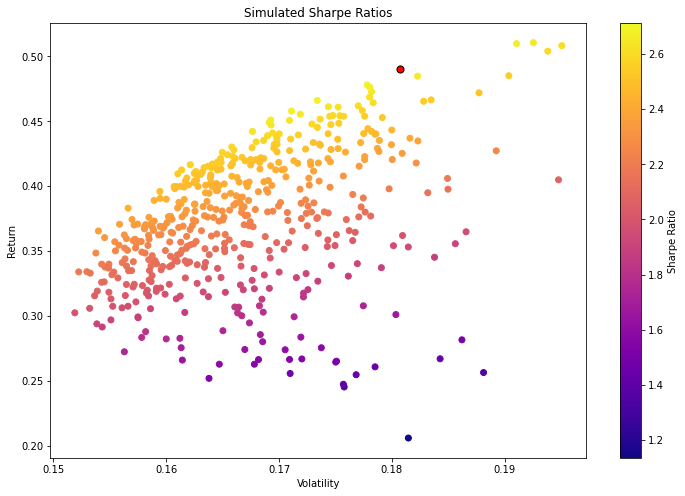

In [11]:
display_results(returns, volatility, sharpe)

### Model Validity

We will verify if the simulation model works as expected, with the help of a few graphs.

#### Normality

First, we evaluate the assumption that investment returns are normally distributed with a histogram and the Shapiro-Wilk normality test. 

As computed below, the average return for the year is 0.0019 and the standard deviation is 0.0114. The histogram appears normally distributed with some significant outliers where a negative return was more than -0.05. However, there is a bit of a skew to the right tail.

In [12]:
best_returns = pd.Series(capital[:,sharpe.argmax()]).pct_change(1)
print('Mean Returns = {}'.format(round(np.mean(best_returns),4)))
print('Std. Deviation of Returns = {}'.format(round(np.std(best_returns),4)))

Mean Returns = 0.0019
Std. Deviation of Returns = 0.0114


Text(0.5, 0, 'Returns')

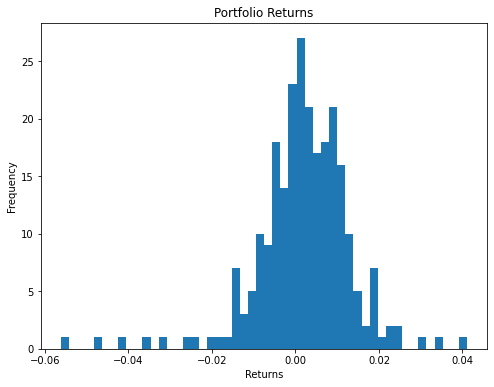

In [13]:
plt.figure(figsize=(8,6))
best_returns.plot(kind='hist', bins=50)
plt.title('Portfolio Returns')
plt.xlabel('Returns')

The p-value for the Shapiro-Wilk test is less than the threshold of 0.05, therefore we reject the null hypothesis that the data comes from the normal distribution. This might be something to be cautious when dealing with real investments. 

In [14]:
shapiro_test = stats.shapiro(capital[:,sharpe.argmax()])
p = shapiro_test[1]
print(p)

0.000429765903390944


In general, abnormalities like kurtosis, fatter tails and higher peaks, or skewness on the distribution can be problematic for the ratio, as standard deviation doesn't have the same effectiveness when these problems exist.

We should also note that the accuracy of Sharpe ratio estimators depends on the statistical properties of returns, and these properties can vary considerably among strategies, portfolios, and over time.

#### Returns

Since the Sharpe Ratio is used as a performance measure, let's compare the performance of the best and worst portfolios. As expected, the best portfolio not only ends the year with higher returns but it also has steadier returns. Notice also that it was immune to the drop suffered by the worst portfolio around day 230 and recovered much quicker from the drop around day 140.

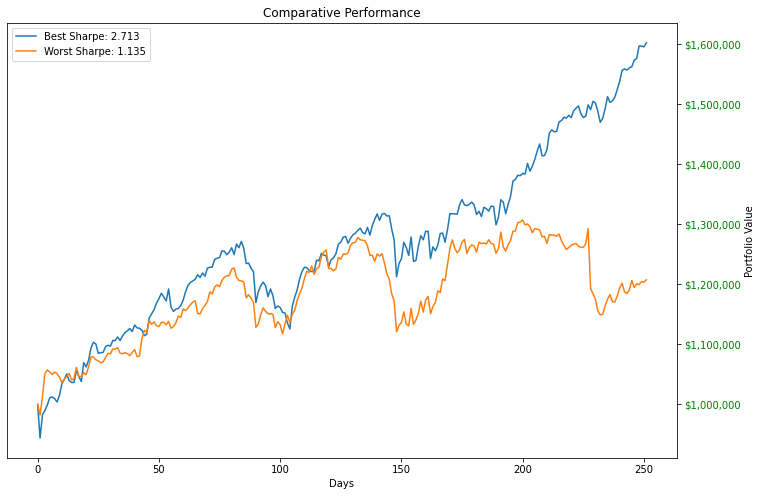

In [19]:
s_arg_max = sharpe.argmax()
s_arg_min = sharpe.argmin()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(capital[:,s_arg_max], label='Best Sharpe: ' + str(round(sharpe.max(),3)))
ax.plot(capital[:,s_arg_min], label='Worst Sharpe: ' + str(round(sharpe.min(),3)))

tick = ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick) 

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_visible(False)
    tick.label2.set_visible(True)
    tick.label2.set_color('green')

plt.title('Comparative Performance')
plt.xlabel('Days')
plt.ylabel('Portfolio Value', )
plt.legend()

## Conclusion

In summary, this Monte Carlo simulation helped us find the best stock allocation in a portfolio composed of five stocks for the year 2019. The best allocation was evaluated via simulation of 500 portfolios and the identification of  the one with the highest sharpe ratio. While this was not the portfolio with the maximum return, it was the most stable with nearly maximal returns. The best allocation was V: 31.1%, BAC: 20.2%, NKE: 5%, AAPL: 40.8%, DLTR: 3% and the porfolio yielded a final value of $1,602,591.85 which is an excellent return largely driven by the gains of Apple and Visa, which comprised the majority of the weights in the optimal portfolio.

While this allocation returned the highest return and shape ratio for the year 2019, there is no guarantee that using this allocation for the year 2020 would yield the same. This could be verified further by backtesting the portfolio performance for the year 2020. 

Additionally, another simulation could be run where the "buy and hold" strategy would be developed to include monthly rebalancing (20 trading days) in order to keep the same initial weights. 

Finally, further exploration would include the use of built-in optimizing functions from SimPy.